<a href="https://colab.research.google.com/github/IEwaspbusters/KopuruVespaCompetitionIE/blob/main/Competition_subs/2021-04-28_submit/batch_LARVAE/HEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Years: Prediction with Mario's Cluster, Population Comercial Density + SearchGridCV

## Import the Data & Modules

In [289]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np
import warnings

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting feature_importance
import graphviz

# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data
from sklearn.model_selection import GridSearchCV

#Cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from plotnine import *

In [290]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [291]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrainYEARS.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredictYEARS.csv", encoding="utf-8") #2020 prediction df
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")
den_com = pd.read_excel("../../../Other_open_data/densidad comercial.xlsx")
cluster= pd.read_csv("../auxiliary_files/WBds_CLUSTERSnests.csv")

In [292]:
den_com_melt= pd.melt(den_com, id_vars=['Código municipio'], value_vars=['2019', '2018', '2017'], var_name='year_offset', 
                      value_name='densidad')
den_com_melt.rename({'Código municipio':'municip_code'}, axis=1, inplace=True)
den_com_melt["densidad"] = den_com_melt["densidad"].apply(lambda x: x.replace(",", "."))
den_com_melt['year_offset']= den_com_melt['year_offset'].apply(str)

## New queen Train dataset

In [293]:
df_train= queen_train.iloc[:,:33]
df_train['year_offset']= df_train['year_offset'].apply(str)

df_train = df_train.merge(den_com_melt,\
             how='left', left_on=['municip_code','year_offset'],\
             right_on=['municip_code','year_offset']).merge(cluster, how='left', on= 'municip_code') #Merge Densidad comercial + Cluster

#Cleaning
df_train.drop(['municip_name_y','station_code'], axis=1, inplace=True)
df_train.rename({'municip_name_x': 'municip_name'}, axis=1, inplace=True)


## New queen predict dataset

In [294]:
queen_predict['year_offset']= queen_predict['year_offset'].apply(str)

df_predict= queen_predict.loc[:,['municip_name', 'municip_code', 'year_offset','population']].merge(den_com_melt,\
             how='left', left_on=['municip_code','year_offset'],\
             right_on=['municip_code','year_offset']).merge(cluster, how='left',on='municip_code')

df_predict.drop(['municip_name_y'], axis=1, inplace=True)
df_predict.rename({'municip_name_x': 'municip_name'}, axis=1, inplace=True)

#Aux to predict (X_Predict)
aux_predict= df_predict.iloc[:,3:]

In [295]:
y = df_train.NESTS

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = df_train.loc[:,['population', 'densidad','Cluster']]

## Forecasting

In [299]:
# Scale the datasets using MinMaxScaler

X_scaled = preprocessing.minmax_scale(X) # this creates a numpy array
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns=X.columns)

In [300]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor(random_state=0, objective="reg:squarederror")

### Use GridSearchCV to find out the best hyperparameters for our XGBoost model with our Fitted Data

In [321]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              "learning_rate": [0.2], 
              "max_depth": [6],
              "gamma" : [0.5],
              #"max_delta_step" : [3],
              "min_child_weight": [9],
              #"subsample": [0.9],
              #"colsample_bytree": [0.4],
              "reg_lambda" : [1.5],
              "n_estimators": [200],
              "scale_pos_weight" : [3.5]
              }

warnings.filterwarnings(action='ignore', category=UserWarning)
grid = GridSearchCV(model, param_grid, cv=3)

#2) Fitting the model with our desired data and check for best results
grid.fit(X_scaled, y)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

The number homogeneous splits conducted by GridSearchCV are: 3.
The best hyperparameters found were: {'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 200, 'reg_lambda': 1.5, 'scale_pos_weight': 3.5}.
The best score found was: 0.048343437324859094.


In [322]:
# Reset warnigns to default (this is used to suppred a warning message from XGBoost model and avoid converting X_train to numpy to keep features name)

warnings.filterwarnings(action='default', category=UserWarning)

In [323]:
model = grid.best_estimator_
model.fit(X_scaled, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F-Score', ylabel='Feature Importance'>

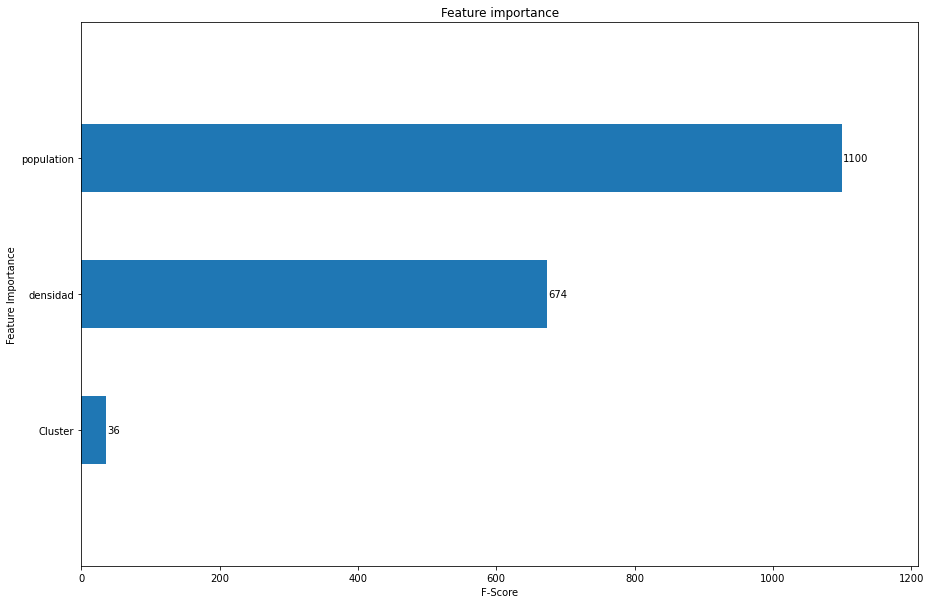

In [324]:
xgb.plot_importance(model, height=0.5, xlabel="F-Score", ylabel="Feature Importance", grid=False, )

<AxesSubplot:>

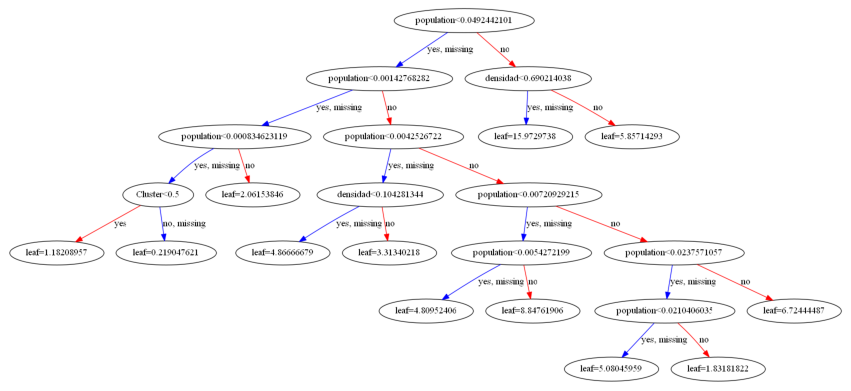

In [326]:
xgb.plot_tree(model)

In [327]:
# make a prediction
X_scaled_pred = preprocessing.minmax_scale(aux_predict)
X_scaled_pred = pd.DataFrame(X_scaled_pred,index=aux_predict.index,columns=aux_predict.columns)
X_scaled_pred = np.ascontiguousarray(X_scaled_pred)

df_predict['nests_2020'] = model.predict(X_scaled_pred)

In [328]:
df_predict.nests_2020.sum()

2839.384

## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [329]:
# Remove the Municipalities to which we did not assign a Cluster, since there was not reliable data for us to predict 

df_predict = df_predict.loc[~df_predict.municip_code.isin([48020]),:]

In [330]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48020],\
             "NOMBRE MUNICIPIO":["Bilbao"],\
             "NIDOS 2020":[0]})

In [331]:
HEX = df_predict.loc[:,["municip_code","municip_name","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [332]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2818


'All Municipality Names and Codes to be submitted match the Template'

In [333]:
# reset max_rows to default values (used in function to see which rows did not match template)

pd.reset_option("max_rows")

In [334]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210608_XGyears_ClusterMB_PC4_Zeros_Gridsearchcv.csv", index=False)